In [2]:
import networkx as nx
import matplotlib.pyplot as plt

class SubAutomaton:
    def __init__(self,id):
        self.id = id
        self.tree = self.generate_tree(3,4)
        
    def generate_tree(self,depth,branching_factor):
        G = nx.Graph()
        
        def add_children(node, current_depth):
            if current_depth < depth:
                for i in range(branching_factor):
                    child = f"{node}-{i}"
                    G.add_edge(node, child)
                    add_children(child, current_depth + 1)
        
        root = "0"
        G.add_node(root)
        add_children(root, 0)
        
        return G
    
    def vis(self):
        nx.draw(self.tree, with_labels=True)
        plt.show()
    
        

In [3]:
from collections import defaultdict
num_modules = 1
num_automata_per_module = 4
num_tokens_in_module = 16

automata_dict = {}
id2module = {}
module2id = defaultdict(list)
for module in range(num_modules):
    for automata in range(num_automata_per_module):
        id = module*num_automata_per_module + automata
        subautomaton = SubAutomaton(id=id)
        automata_dict[id]=subautomaton
        id2module[id] = module
        module2id[module].append(id)


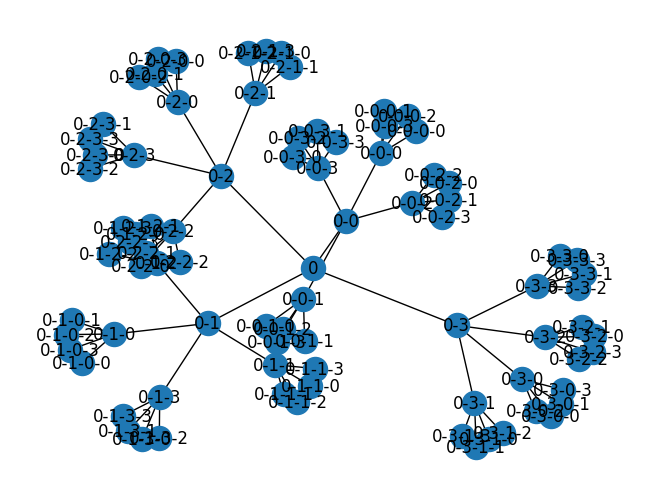

In [4]:
automata_dict[0].vis()

In [5]:
node2token = {}
token2node = {}

ix = 0
for automata in automata_dict:
    for node in automata_dict[automata].tree.nodes:
        node2token[(automata,node)] = ix
        token2node[ix] = (automata,node)
        ix += 1
print(len(node2token.keys()))
len(automata_dict.keys())

340


4

In [27]:
import random
num_enabling = 1
for automata in automata_dict:
    current_id = automata
    for edge in automata_dict[automata].tree.edges:
        enabling = []
        for i in range(num_enabling):
            automata_id = random.choice(list(automata_dict.keys()))
            while automata_id == current_id:
                automata_id = random.randint(0, num_automata_per_module - 1)
            # sample random node from the automata
            node = random.choice(list(automata_dict[automata_id].tree.nodes))
            enabling.append({'automata_id':automata_id,'node_id':node})
        automata_dict[automata].tree.edges[edge]['enabling'] = enabling
            

In [22]:
def get_path(target_dict,depth=0):
    if depth == 2:
        return None
    automata_id = target_dict['automata_id']
    end_node = target_dict['node_id']
    two_hop_nodes = []
    for node in automata_dict[automata_id].tree.nodes:
        shortest_path = nx.shortest_path(automata_dict[automata_id].tree, source=node, target=end_node)
        if len(shortest_path) == 2 or len(shortest_path) == 2:
            # get first edge on the shortest path from start_node to end_node
            first_edge = (shortest_path[0],shortest_path[1])
            two_hop_nodes.append((node,first_edge))
    assert len(two_hop_nodes) > 0, "No 2-hop nodes found"
    start_node,first_edge = random.choice(two_hop_nodes)
    # get the enabling of the first edge
    enabling = automata_dict[automata_id].tree.edges[first_edge]['enabling']
    # sample two independent enabling from the enabling
    enabling_1 = random.choice(enabling)
    #enabling_2 = random.choice(enabling)
    #while enabling_1 == enabling_2:
    #    enabling_2 = random.choice(enabling)
    subgoal = get_path(enabling_1,depth=depth+1)
    return {'automata_id':automata_id,'end_node':end_node,'start_node':start_node,'first_edge':first_edge,'subgoal':subgoal,}




In [23]:
def get_module_nodes(path):
    end_automaton = path['automata_id']
    end_automaton_end_node = path['end_node']
    end_automaton_start_node = path['start_node']
    subgoal_automaton = path['subgoal']['automata_id']
    subgoal_automaton_end_node = path['subgoal']['end_node']
    subgoal_automaton_start_node = path['subgoal']['start_node']
    #first_automaton = path['subgoal']['subgoal']['automata_id']
    #first_automaton_end_node = path['subgoal']['subgoal']['end_node']
    #first_automaton_start_node = path['subgoal']['subgoal']['start_node']


    module_nodes = defaultdict(list)
    for module in range(num_modules):
        used_automata = []
        if module == id2module[end_automaton]:
            module_nodes[module].append((end_automaton,end_automaton_start_node))
            used_automata.append(end_automaton)
        if module == id2module[subgoal_automaton]:
            module_nodes[module].append((subgoal_automaton,subgoal_automaton_end_node))
            used_automata.append(subgoal_automaton)
        #if module == id2module[first_automaton]:
        #    module_nodes[module].append((first_automaton,first_automaton_end_node)) # end node
        #    used_automata.append(first_automaton)
        num_missing = num_tokens_in_module-len(module_nodes[module])
        for i in range(num_missing):
            available = module2id[module]
            # sample random automata in the module different from the ones in the used_automata list
            automata_id = random.choice(list(set(available)-set(used_automata)))
            node = random.choice(list(automata_dict[automata_id].tree.nodes))
            module_nodes[module].append((automata_id,node))
    return {
        'end_automaton':(end_automaton,end_automaton_start_node),
        'subgoal_automaton':(subgoal_automaton,subgoal_automaton_end_node),
        #'first_automaton':(first_automaton,first_automaton_end_node),
        'init':(end_automaton,end_automaton_end_node),
        'module_nodes':module_nodes
    }

def get_example():
    # sample random automata
    automata_id = random.choice(list(automata_dict.keys()))
    # sample random node from the automata
    end_node = random.choice(list(automata_dict[automata_id].tree.nodes))
    target_dict = {'automata_id':automata_id,'node_id':end_node}
    # Get all nodes that are 2 hops away from the end_node
    path = get_path(target_dict,depth=0)
    item = get_module_nodes(path)
    end_token = node2token[item['end_automaton']]
    subgoal_token = node2token[item['subgoal_automaton']]
    #first_token = node2token[item['first_automaton']]
    init_token = node2token[item['init']]
    module_tokens_dict = defaultdict(list)
    for module in item['module_nodes']:
        module_tokens = []
        for automata, node in item['module_nodes'][module]:
            module_tokens.append(node2token[(automata, node)])
        random.shuffle(module_tokens)
        module_tokens_dict[module] = module_tokens
    # concat all module tokens
    string_tokens = []
    for module in module_tokens_dict:
        string_tokens.extend(module_tokens_dict[module])
    # get position of the end token in the module tokens
    string_tokens.append(init_token)
    end_token_position = string_tokens.index(end_token)  + len(node2token)
    # get position of the subgoal token in the module tokens
    subgoal_token_position = string_tokens.index(subgoal_token) + len(node2token)
    # get position of the first token in the module tokens
    #first_token_position = string_tokens.index(first_token)  + len(node2token
    # get position of the init token in the module tokens

    example = {
        'input':string_tokens,
        #'first_token':first_token_position,
        'end_token':end_token_position,
        'first_token':subgoal_token_position,
        'init_token':init_token}
    return example

In [29]:
import random
def get_tripples():
    triples = []
    for automata in automata_dict:
        # get all pairs of nodes in the automata
        for node in automata_dict[automata].tree.nodes:
            for node2 in automata_dict[automata].tree.nodes:
                if node != node2:
                    # get shortest path between the two nodes
                    shortest_path = nx.shortest_path(automata_dict[automata].tree, node, node2)
                    if len(shortest_path) <= 2:
                        continue
                    # convert path nodes to tokens
                    enabling = automata_dict[automata].tree.edges[(shortest_path[0],shortest_path[1])]['enabling'][0]
                    en_automata = enabling['automata_id']
                    en_node = enabling['node_id']
                    triples.append({'start':node2token[(automata,shortest_path[0])],
                                                'end':node2token[(automata,shortest_path[-1])],
                                                'subgoal':node2token[(automata,shortest_path[1])],
                                                'enabling':node2token[(en_automata,en_node)],
                                        'automata':automata})
    return triples
triples = get_tripples()
random.shuffle(triples)
num_train_triples = int(len(triples)*0.8)
train_triples = triples[:num_train_triples]
test_triples = triples[num_train_triples:]

def get_example_from_triple(triple):
    start_token = triple['start']
    end_token = triple['end']
    subgoal_token = triple['enabling']#triple['subgoal']
    automata_id = triple['automata']
    num_distractors = 10
    distractors = []
    while len(distractors) < num_distractors:
        #distractor_token = random.choice(list(range(341,400)))
        # sample random automata different from the automata_id
        distractor_automata_id = random.choice(list(set(automata_dict.keys())-set([automata_id])))
        distractor_node = random.choice(list(automata_dict[distractor_automata_id].tree.nodes))
        distractor_token = node2token[(distractor_automata_id, distractor_node)]
        distractors.append(distractor_token)

    example = distractors + [start_token]
    random.shuffle(example)
    example += [end_token,subgoal_token]
    example = {'input':example} # Update the example dictionary
    return example
    


In [30]:
def get_example():
    # sample random automata
    automata_id = random.choice(list(automata_dict.keys()))
    # sample random node from the automata
    end_node = random.choice(list(automata_dict[automata_id].tree.nodes))
    start_node = random.choice(list(automata_dict[automata_id].tree.nodes))
    # Get the shortest path between start_node and end_node
    shortest_path = nx.shortest_path(automata_dict[automata_id].tree, start_node, end_node)
    if len(shortest_path) <= 2:
        return get_example()
    # Convert path nodes to tokens
    path_tokens = [node2token[(automata_id, node)] for node in shortest_path]
    start_token = path_tokens[0]
    end_token = path_tokens[-1]
    subgoal_token = path_tokens[1]
    # sample distractors
    num_distractors = 7
    distractors = []
    while len(distractors) < num_distractors:
        #distractor_token = random.choice(list(range(341,400)))
        # sample random automata different from the automata_id
        distractor_automata_id = random.choice(list(set(automata_dict.keys())-set([automata_id])))
        distractor_node = random.choice(list(automata_dict[distractor_automata_id].tree.nodes))
        distractor_token = node2token[(distractor_automata_id, distractor_node)]
        distractors.append(distractor_token)

    example = distractors + [start_token]
    random.shuffle(example)
    example += [end_token,subgoal_token]
    example = {'input':example} # Update the example dictionary

    return example

In [31]:
from tqdm import tqdm
import pickle

num_test_examples = 5000
num_train_examples = 200000
train_examples = []
num_duplicates = 1
for i in range(num_duplicates):
    for example in tqdm(train_triples):
        example = get_example_from_triple(example)
        train_examples.append(example)
test_examples = []
for example in tqdm(test_triples):
    example = get_example_from_triple(example)
    test_examples.append(example)

data = {'train':train_examples,'test':test_examples,'vocab':list(token2node.keys())}

# Save train examples
with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)



100%|██████████| 5578/5578 [00:00<00:00, 45114.74it/s]


In [17]:
train_examples[0]

{'input': [253, 363, 394, 354, 356, 398, 387, 370, 396, 385, 362, 239, 250]}